# 💹Prediction of Stock Returns with Machine Learning Models

## 🔧Preparing the tools

In [83]:
# Import all the tools

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

# Models from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# Datareader and datetime module
from pandas_datareader import data
import datetime

## 📇Load Data

In [84]:
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime.today()

>**Let's analyze the data of `Kotak Mahindra Bank` for predicting the stock returns, as it shows the best growth over other banks.**

In [85]:
# Getting the dataset
kotak_df = data.DataReader("KOTAKBANK.NS", data_source='yahoo', start=start_date, end=end_date)

kotak_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-01,366.024994,360.375000,366.000000,361.274994,785536.0,359.863800
2014-01-02,365.725006,351.500000,361.299988,353.700012,912278.0,352.318420
2014-01-03,358.149994,348.299988,353.549988,356.274994,1145134.0,354.883362
2014-01-06,358.500000,352.799988,355.000000,357.049988,893430.0,355.655334
2014-01-07,357.500000,350.000000,356.000000,354.075012,1287588.0,352.691956


## 🔎Data Exploration

In [86]:
kotak_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1796 entries, 2014-01-01 to 2021-04-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1796 non-null   float64
 1   Low        1796 non-null   float64
 2   Open       1796 non-null   float64
 3   Close      1796 non-null   float64
 4   Volume     1796 non-null   float64
 5   Adj Close  1796 non-null   float64
dtypes: float64(6)
memory usage: 98.2 KB


In [87]:
# Get the number of rows and columns in the data set
kotak_df.shape

(1796, 6)

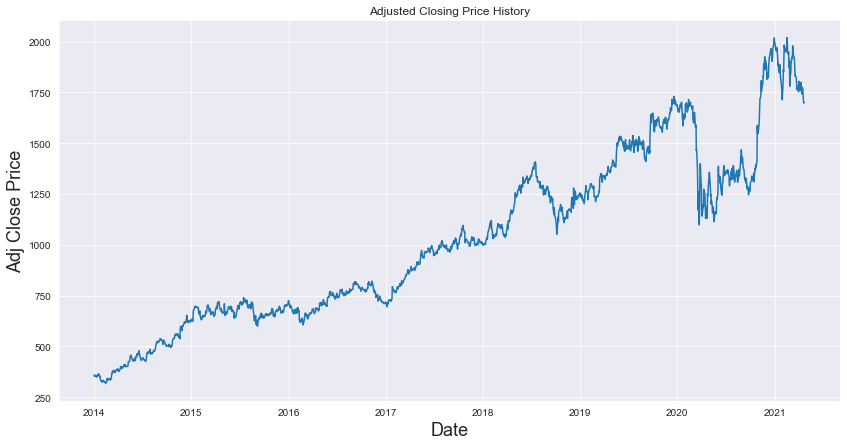

In [88]:
# Visualize the Adjusted Closing Price (Adj Close) history
plt.figure(figsize=(14, 7))
plt.plot(kotak_df["Adj Close"])
plt.title("Adjusted Closing Price History")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close Price", fontsize=18);

## 🎨Getting Data Ready

In [89]:
# Number of days in future
forecast_out = 30

In [90]:
# A new "Prediction" column for the prediction
kotak_df["Predictions"] = kotak_df["Adj Close"].shift(-forecast_out)

kotak_df

,High,Low,Open,Close,Volume,Adj Close,Predictions
Date,,,,,,,
2014-01-01,366.024994,360.375000,366.000000,361.274994,785536.0,359.863800,323.506409
2014-01-02,365.725006,351.500000,361.299988,353.700012,912278.0,352.318420,317.156311
2014-01-03,358.149994,348.299988,353.549988,356.274994,1145134.0,354.883362,321.962463
2014-01-06,358.500000,352.799988,355.000000,357.049988,893430.0,355.655334,324.104034
2014-01-07,357.500000,350.000000,356.000000,354.075012,1287588.0,352.691956,338.821350
...,...,...,...,...,...,...,...
2021-04-15,1809.500000,1752.599976,1800.000000,1773.250000,3546886.0,1773.250000,NaN
2021-04-16,1788.150024,1760.050049,1774.000000,1764.099976,2912279.0,1764.099976,NaN
2021-04-19,1720.000000,1675.000000,1720.000000,1700.750000,3865423.0,1700.750000,NaN


In [91]:
# Split data into X (features) and y (label)
X = kotak_df[["Adj Close"]][:-forecast_out]
y = kotak_df["Predictions"][:-forecast_out]

In [92]:
# train, test, and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Feature Scaling

In [93]:
# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Fit the X_train dataset
scaler.fit(X_train)

# transform the scaled data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

## 📐Modelling

In [94]:
# Create an evaluation function (the competition uses RMSLE)

def rmsle(y_test, y_preds):
    """
    Calculate root mean squared log error (RMSLE) between predictions and the true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    """
    Return scores for training and validation sets.
    Note: If the testing score is higher than the training score in MAE and RMSLE, then our model is not Overfitted. 
    """
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Testing MAE": mean_absolute_error(y_test, test_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Testing RMSLE": rmsle(y_test, test_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Testing R^2": r2_score(y_test, test_preds)}
    return scores

In [95]:
# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models.
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : testing labels
    """
    # Dictionay to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        
        # Fit the model to the data
        model.fit(X_train, y_train)
        
        # Evaluate the model and append its scores to model_scores
        model_scores[name] = show_scores(model)
    
    return model_scores

In [96]:
# Put models in a dictionary
models = {"Linear Regression": LinearRegression(),
          "Random Forest Regression": RandomForestRegressor(),
          "Support Vector Machine": SVR(),
          "Bayesian Ridge Regression": BayesianRidge(),
          "Gradient Boosting Regression": GradientBoostingRegressor()}

In [97]:
# Getting results of different regression models
model_scores = fit_and_score(models=models, 
                             X_train=X_train, 
                             X_test=X_test, 
                             y_train=y_train, 
                             y_test=y_test)

### Model Evaluation

In [98]:
print("-"*50)
for key, value in model_scores.items():
    print(key + ": ")
    for k, v in value.items():
        print("\t" + k + ":", end=" ")
        print(v)
    print("-"*50)

--------------------------------------------------
Linear Regression: 
	Training MAE: 64.77340768815793
	Testing MAE: 65.83806957131192
	Training RMSLE: 0.08440771268484024
	Testing RMSLE: 0.08691190706304407
	Training R^2: 0.9331144365931608
	Testing R^2: 0.9282446441172985
--------------------------------------------------
Random Forest Regression: 
	Training MAE: 26.07971933731347
	Testing MAE: 73.78508177205897
	Training RMSLE: 0.03362209251392666
	Testing RMSLE: 0.09694442926056414
	Training R^2: 0.9888634865951123
	Testing R^2: 0.9073017176993411
--------------------------------------------------
Support Vector Machine: 
	Training MAE: 150.25794128398442
	Testing MAE: 146.89499757448885
	Training RMSLE: 0.22939065521862673
	Testing RMSLE: 0.2263530899138807
	Training R^2: 0.6671929796583757
	Testing R^2: 0.6982918775577069
--------------------------------------------------
Bayesian Ridge Regression: 
	Training MAE: 64.77514387451093
	Testing MAE: 65.8397436717626
	Training RMSLE:

### Cross Validation Score

In [99]:
print("-"*50)
for key, value in models.items():
    print(key + ":", end="     ")
    cvs = cross_val_score(value, X, y, cv=5, scoring="neg_mean_absolute_error")
    print(np.mean(cvs))
    print("-"*50)

--------------------------------------------------
Linear Regression:     -67.97771630549586
--------------------------------------------------
Random Forest Regression:     -129.97182678799487
--------------------------------------------------
Support Vector Machine:     -222.43065571126846
--------------------------------------------------
Bayesian Ridge Regression:     -67.9829698560632
--------------------------------------------------
Gradient Boosting Regression:     -122.60706219700617
--------------------------------------------------


### Train the ideal models

#### Linear Regression Model:

In [100]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# score for Linear Regression model
show_scores(lr_model)

{'Training MAE': 64.77340768815793,
 'Testing MAE': 65.83806957131192,
 'Training RMSLE': 0.08440771268484024,
 'Testing RMSLE': 0.08691190706304407,
 'Training R^2': 0.9331144365931608,
 'Testing R^2': 0.9282446441172985}

In [101]:
# Cross Validation Score for Linear Regression
print("Negative Mean Absolute Error:", end="\t")
print(cross_val_score(lr_model, X, y, scoring="neg_mean_absolute_error").mean())

Negative Mean Absolute Error:	-67.97771630549586


#### Bayesian Ridge Regression:

In [102]:
br_model = BayesianRidge(compute_score=True, normalize=True)
br_model.fit(X_train, y_train)

# score for Bayesian Ridge Regression model
show_scores(br_model)

{'Training MAE': 64.77514387451093,
 'Testing MAE': 65.83974367176259,
 'Training RMSLE': 0.08441127092279979,
 'Testing RMSLE': 0.08691520717955126,
 'Training R^2': 0.933114433449775,
 'Testing R^2': 0.9282436360159583}

In [103]:
# Cross Validation Score for ideal_model
print("Negative Mean Absolute Error:", end="\t")
print(cross_val_score(br_model, X, y, scoring="neg_mean_absolute_error").mean())

Negative Mean Absolute Error:	-67.98296985606319


### Visualize the model evaluation

#### Perfect Predictions vs Actual Predictions

#### Linear Regression

In [104]:
lr_predictions = lr_model.predict(X_test)

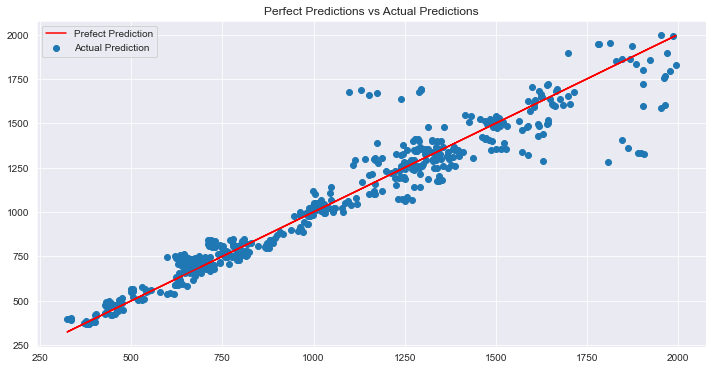

In [105]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, lr_predictions)
plt.plot(y_test, y_test, "-r")
plt.legend(["Prefect Prediction", "Actual Prediction"])
plt.title("Perfect Predictions vs Actual Predictions");

#### Bayesian Ridge Regression:

In [106]:
br_predictions = br_model.predict(X_test)

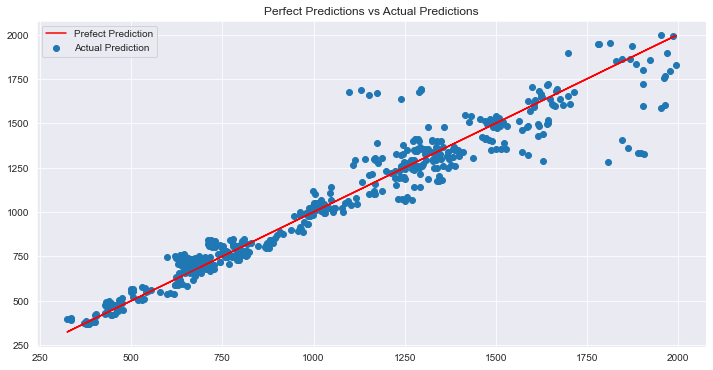

In [107]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, br_predictions)
plt.plot(y_test, y_test, "-r")
plt.legend(["Prefect Prediction", "Actual Prediction"])
plt.title("Perfect Predictions vs Actual Predictions");

## 💾Save the model

Exporting the BayesianRidge() model and the LinearRegression() model with the help of `"joblib"`

In [111]:
from joblib import dump, load

In [112]:
# Save lr_model to file
dump(value=lr_model,
     filename="model/linear_regression_model.joblib")

['model/linear_regression_model.joblib']

In [113]:
# Save br_model to file
dump(value=br_model,
     filename="model/bayesian_ridge_regression_model.joblib")

['model/bayesian_ridge_regression_model.joblib']

In [114]:
# Load the model
loaded_lr_model = load(filename="model/linear_regression_model.joblib")
loaded_br_model = load(filename="model/bayesian_ridge_regression_model.joblib")

# Get predictions
lr_preds = loaded_lr_model.predict(X_test)
br_preds = loaded_br_model.predict(X_test)

# Root Mean Squared Error and Mean Absolute Error
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
br_rmse = np.sqrt(mean_squared_error(y_test, br_preds))
lr_mae = mean_absolute_error(y_test, lr_preds)
br_mae = mean_absolute_error(y_test, br_preds)

print("Linear Regression Model:")
print(f"Root Mean Squared Error: {lr_rmse}")
print(f"Mean Absolute Error: {lr_mae}")

print()

# Root Mean Squared Error and Mean Absolute Error


print("Bayesian Ridge Regression:")
print(f"Root Mean Squared Error: {br_rmse}")
print(f"Mean Absolute Error: {br_mae}")

Linear Regression Model:
Root Mean Squared Error: 109.95660065987005
Mean Absolute Error: 65.83806957131192

Bayesian Ridge Regression:
Root Mean Squared Error: 109.95737305522506
Mean Absolute Error: 65.83974367176259
